In [1]:
from pyspark.sql import SparkSession
import os
from pyspark.sql.functions import col, asc
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
        .master("local[*]") \
        .appName("data_processing") \
        .getOrCreate()
sc = spark.sparkContext

In [2]:
stocks = spark.read.csv('/project/ds5559/group4folder/Data/Stocks/', header = True, inferSchema=True).withColumn("stock", F.input_file_name())
stocks = stocks.withColumn('high_low_diff', stocks.High-stocks.Low)
stocks = stocks.withColumn("stock", F.split("stock","/"))
stocks = stocks.withColumn("stock", stocks.stock.getItem(F.size("stock")-1))
stocks = stocks.withColumn("stock", F.split("stock", '\.').getItem(0))

stocks = stocks.filter(stocks.stock!='drys')
# stocks.show()

In [3]:
max_stocks = stocks.filter(stocks.Date=='2017-11-10').select('stock')
min_stocks = stocks.filter(stocks.Date=='1990-12-10').select('stock')

min_stocks = [i.__getitem__('stock') for i in min_stocks.collect()]
max_stocks = [i.__getitem__('stock') for i in max_stocks.collect()]

stocks_to_use = stocks.filter(stocks.stock.isin(max_stocks) & stocks.stock.isin(min_stocks))
stocks_to_use = stocks_to_use.filter(stocks.Date>='1990-12-10')

In [4]:
stocks_to_use.createOrReplaceTempView("stocks")

sql = "SELECT stock, Date as ds, Close as y FROM stocks ORDER BY stock, ds"
stock_part = (spark.sql(sql).repartition(spark.sparkContext.defaultParallelism, ['stock'])).cache()

In [5]:
# https://stackoverflow.com/questions/71203431/error-loading-dataframe-to-bigquery-table-pyarrow-lib-arrowtypeerror-object-of
from pyspark.sql.types import *
result_schema = StructType([
                  StructField('stock', StringType()),
                  StructField('MSE', DoubleType())
            ])

In [ ]:
stock_part.show(10)

In [6]:
# from pyspark.sql.functions import pandas_udf, PandasUDFType
# from pmdarima.arima import auto_arima
# import pandas as pd

# @pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
# def forecast_stock(stock_pd):
    
#     stock_pd.set_index('ds',inplace=True)
    
#     train = stock_pd.y[:-10]
#     test = stock_pd.y[-10:]

#     arima_model = auto_arima(train, start_p=0, d=1, start_q=0,
#             max_p=2, max_d=1, max_q=2, start_P=0,
#             D=1, start_Q=0, max_P=2, max_D=2,
#             max_Q=5, m=12, seasonal=True,
#             error_action='warn',trace = True,
#             supress_warnings=True, stepwise = True,
#             random_state=20,n_fits = 50 )
    
#     prediction = pd.DataFrame(arima_model.predict(n_periods = 10), index=test.index)
#     # MSE = ((prediction[0] - test)**2).mean()
    
#     result_pd = prediction.rename({0:'y_hat'},axis=1)
#     result_pd['y'] = test
#     result_pd['stock'] = stock_pd['stock'].iloc[0]
    
#     result_pd = result_pd.reset_index()
    
#     # https://stackoverflow.com/questions/59845208/pyspark-pyarrow-lib-arrowtypeerror-an-integer-is-required-got-type-timestamp
#     result_pd['ds'] = pd.to_datetime(result_pd.ds)
    
#     result_pd['squared_error'] = (result_pd['y'] - result_pd['y_hat'])**2
    
#     mse = result_pd.groupby('stock').mean()['squared_error']
    
#     mse = mse.reset_index()
#     mse.rename({'squared_error':'MSE'},axis=1,inplace=True)
    
#     mse = mse.sort_values(by = 'MSE', ascending=False)
    
#     return mse

# results1 = stock_part.groupby('stock').apply(forecast_stock)
# results1.cache()
# results1.orderBy(results1.MSE, ascending=False).show()

In [7]:
from pyspark.sql.types import *
result_schema = StructType([
                  StructField('ds', TimestampType()),
                  StructField('stock', StringType()),
                  StructField('y', DoubleType()),
                  StructField('y_hat', DoubleType())
])

In [8]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pmdarima.arima import auto_arima
import pandas as pd

# # https://medium.com/towards-data-science/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
# # https://machinelearningmastery.com/make-sample-forecasts-arima-python/
# # https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_stock(stock_pd):
    
    stock_pd.set_index('ds',inplace=True)
    
    train = stock_pd.y[:-5]
    test = stock_pd.y[-5:]
    # borrowed directly from the auto-arima medium article written by Sushmitha Pulagam
    arima_model = auto_arima(train, start_p=0, d=1, start_q=0,
            max_p=1, max_d=1, max_q=1, start_P=0,
            D=1, start_Q=0, max_P=1, max_D=1,
            max_Q=5, m=12, seasonal=True,
            error_action='warn',trace = True,
            supress_warnings=True, stepwise = True,
            random_state=20,n_fits = 50 )
    
    prediction = pd.DataFrame(arima_model.predict(n_periods = 5), index=test.index)
    # MSE = ((prediction[0] - test)**2).mean()
    
    result_pd = prediction.rename({0:'y_hat'},axis=1)
    result_pd['y'] = test
    result_pd['stock'] = stock_pd['stock'].iloc[0]
    
    result_pd = result_pd.reset_index()
    
    # https://stackoverflow.com/questions/59845208/pyspark-pyarrow-lib-arrowtypeerror-an-integer-is-required-got-type-timestamp
    result_pd['ds'] = pd.to_datetime(result_pd.ds)
    
    return result_pd

In [9]:
import pyspark.sql.functions as F
# from pyspark.sql.functions import current_date
results1 = stock_part.groupby('stock').apply(forecast_stock)
results1.cache()
res1 = results1.withColumn("Squared_Error", (results1.y - results1.y_hat)**2)
res1.cache()
# res_pandas = res1.toPandas()
res2 = res1.groupBy('stock').agg(F.mean('Squared_Error').alias('MSE')).orderBy('MSE')
res2.cache()
res2.show(10)

# res1.createOrReplaceTempView("all_stocks")
# query = ('select stock, avg(Squared_Error) as mse from all_stocks group by stock order by mse desc limit 10')
# res2 = spark.sql(query)

# res2.write.csv("../../project/ds5559/group4folder/ds5110_stock_project/all_stocks.csv")

# res2.orderBy(res2.mse, ascending=False).show(10)

/usr/local/spark/python/pyspark/sql/pandas/group_ops.py:84: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


+-----+--------------------+
|stock|                 MSE|
+-----+--------------------+
|  avp|0.010319093590561278|
|  abx|0.011756680065030542|
|  pgr|0.017827850434356755|
|  tkf|  0.0293119016900948|
|  uis| 0.02957331497772072|
|   gt|0.031475959690598576|
|   ni|0.038632136368114016|
|  exc|0.047285360264716504|
| gntx| 0.04882993940832579|
|  cnp|  0.0491835727387909|
+-----+--------------------+
only showing top 10 rows



In [11]:
res2.filter(res2.stock != 'brk-a').agg(F.mean('MSE').alias('Average_MSE')).show()

+-----------------+
|      Average_MSE|
+-----------------+
|7.835037839675834|
+-----------------+



In [12]:
res1.show(10)

+-------------------+-----+------+------------------+--------------------+
|                 ds|stock|     y|             y_hat|       Squared_Error|
+-------------------+-----+------+------------------+--------------------+
|2017-11-06 00:00:00| adbe| 180.8|191.80064618013017|  121.01421638041231|
|2017-11-07 00:00:00| adbe|180.89|193.39011081142718|  156.25277029795896|
|2017-11-08 00:00:00| adbe|184.06|192.85149116912527|   77.29031697680753|
|2017-11-09 00:00:00| adbe|181.92|192.99920291852115|  122.74873730976783|
|2017-11-10 00:00:00| adbe|181.72|193.32553631880745|  134.68847324715884|
|2017-11-06 00:00:00|  bax| 64.36| 64.43290311005222|0.005314863455286611|
|2017-11-07 00:00:00|  bax| 64.32| 64.63295122266699| 0.09793846776876766|
|2017-11-08 00:00:00|  bax| 65.01| 64.80273471590051|0.042958897992843116|
|2017-11-09 00:00:00|  bax| 65.39| 65.01772569478524|  0.1385881583231317|
|2017-11-10 00:00:00|  bax| 64.04| 64.30227764606018| 0.06878956362286376|
+-------------------+----

In [14]:
res1.show(10)

+-------------------+-----+------+------------------+--------------------+
|                 ds|stock|     y|             y_hat|       Squared_Error|
+-------------------+-----+------+------------------+--------------------+
|2017-11-06 00:00:00| adbe| 180.8|191.80064618013017|  121.01421638041231|
|2017-11-07 00:00:00| adbe|180.89|193.39011081142718|  156.25277029795896|
|2017-11-08 00:00:00| adbe|184.06|192.85149116912527|   77.29031697680753|
|2017-11-09 00:00:00| adbe|181.92|192.99920291852115|  122.74873730976783|
|2017-11-10 00:00:00| adbe|181.72|193.32553631880745|  134.68847324715884|
|2017-11-06 00:00:00|  bax| 64.36| 64.43290311005222|0.005314863455286611|
|2017-11-07 00:00:00|  bax| 64.32| 64.63295122266699| 0.09793846776876766|
|2017-11-08 00:00:00|  bax| 65.01| 64.80273471590051|0.042958897992843116|
|2017-11-09 00:00:00|  bax| 65.39| 65.01772569478524|  0.1385881583231317|
|2017-11-10 00:00:00|  bax| 64.04| 64.30227764606018| 0.06878956362286376|
+-------------------+----

In [25]:
final_df = res1.filter(res1.stock != 'brk-a').toPandas()
final_df = final_df.set_index('ds')
print(len(final_df))
final_df = final_df[final_df.index.dayofweek < 5]
print(len(final_df))

1220
1220


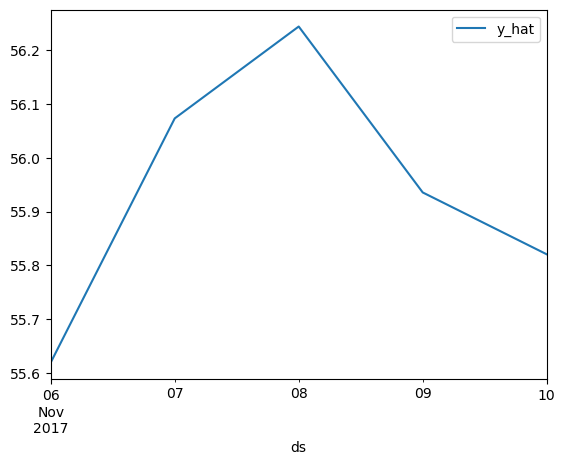

In [17]:
final_df.query("stock=='abt'")[['y_hat']].plot()
plt.show()

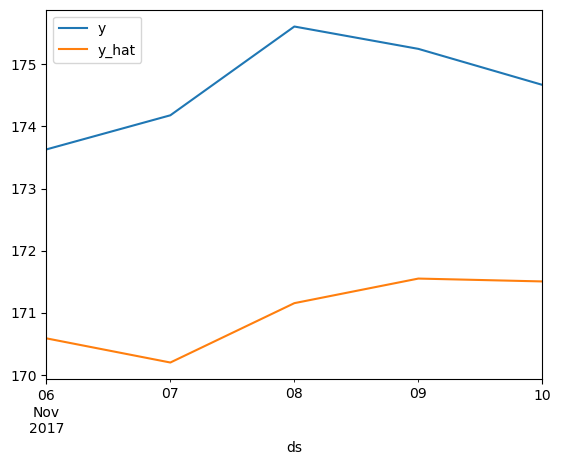

In [18]:
final_df.query("stock=='aapl'")[['y','y_hat']].plot()
plt.show()

In [20]:
final_df.head()

,stock,y,y_hat,Squared_Error
ds,,,,
2017-11-06,adbe,180.80,191.800646,121.014216
2017-11-07,adbe,180.89,193.390111,156.252770
2017-11-08,adbe,184.06,192.851491,77.290317
2017-11-09,adbe,181.92,192.999203,122.748737
2017-11-10,adbe,181.72,193.325536,134.688473


In [26]:
new = final_df.loc[final_df.index>'2017-11-05']
# new['squared_error'] = (new['y'] - new['y_hat'])**2
stock_mse = new.groupby('stock')['Squared_Error'].mean()

In [27]:
new[new.Squared_Error>new.Squared_Error.quantile(.99)]

,stock,y,y_hat,Squared_Error
ds,,,,
2017-11-07,adbe,180.89,193.390111,156.252770
2017-11-08,hum,243.48,259.291146,249.992342
2017-11-09,hum,247.46,260.214060,162.666047
2017-11-10,hum,244.39,258.027852,185.991003
2017-11-09,gww,204.79,192.417974,153.067038
2017-11-10,gww,203.48,190.601054,165.867253
2017-11-09,mmm,228.39,242.504415,199.216698
2017-11-10,mmm,227.45,244.134219,278.363147
2017-11-07,shw,394.01,406.918393,166.626619


In [29]:
new = final_df.loc[final_df.index>'2017-11-05'].reset_index()
new = new.loc[new.ds=='2017-11-6'].set_index(['stock']).join(new.loc[new.ds=='2017-11-10',['stock','y_hat','y']].set_index(['stock']).rename({'y_hat':'yhatFinal','y':'yFinal'},axis=1))
new['predicted_gain'] = (new.yhatFinal-new.y_hat)/new.y_hat
new['gain'] = (new.yFinal-new.y)/new.y
new.sort_values(by='predicted_gain',ascending=False).head(50)['gain'].mean()

-0.009236068998007805

In [30]:
new.sort_values(by='predicted_gain',ascending=False)

,ds,y,y_hat,Squared_Error,yhatFinal,yFinal,predicted_gain,gain
stock,,,,,,,,
mmm,2017-11-06,230.31,233.663528,11.246148,244.134219,227.45,0.044811,-0.012418
vfc,2017-11-06,69.07,69.824967,0.569975,72.775770,69.63,0.042260,0.008108
jcp,2017-11-06,2.53,2.349661,0.032522,2.431694,3.17,0.034913,0.252964
dov,2017-11-06,96.12,94.200640,3.683941,97.304208,93.79,0.032946,-0.024241
avy,2017-11-06,107.07,107.135070,0.004234,110.526533,105.19,0.031656,-0.017559
...,...,...,...,...,...,...,...,...
ge,2017-11-06,20.13,20.485447,0.126343,18.755657,20.49,-0.084440,0.017884
odp,2017-11-06,3.22,3.240424,0.000417,2.886395,3.27,-0.109254,0.015528
mbi,2017-11-06,6.71,6.888108,0.031722,6.019021,8.90,-0.126172,0.326379


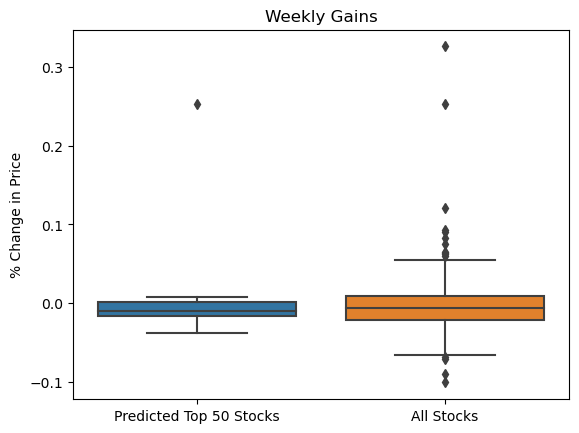

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

top = new.sort_values(by='predicted_gain',ascending=False).head(10)
other = new.sort_values(by='predicted_gain',ascending=False)

ax = sns.boxplot(data=[top['gain'].values,other['gain'].values])
plt.xticks(np.arange(2), ['Predicted Top 50 Stocks','All Stocks'])
plt.ylabel('% Change in Price')
plt.title("Weekly Gains")
plt.show()